<h1 style="display: flex; align-items: center; justify-content: space-between;">
  Music Information Retrieval
  <img src="https://www.upf.edu/documents/8071534/8177261/MTG_logo-07.png/c5d8ed89-90cf-7fbb-6116-1ab41706aa85?t=1578480743718"
       alt="MTG logo"
       width="180"
       style="vertical-align: middle; margin-left: 20px;" />
</h1>

This notebook is part of the **Music Information Retrieval (MIR)** course within the  
[**Sound and Music Computing (SMC)**](https://www.upf.edu/web/smc) programme  
at the **Music Technology Group (MTG), Universitat Pompeu Fabra**.

---

### How to Run the Notebook
You can download the notebook and run it locally on your computer.

Alternatively, to access some GPU time for free, open it directly in **Google Colab** using the badge below:

<a target="_blank"
   href="https://colab.research.google.com/github/mrocamora/mir_course/blob/main/notebooks/MIR_course-sound_classification_deep_learning_mel-spectrogram.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg"
       alt="Open in Colab" />
</a>

---

## Sound classification - deep-learning pipeline
### End-to-end classification using deep learning on the mel-spectrogram

### About this notebook

We will explore sound classification addressing the task of [Mridangam](https://en.wikipedia.org/wiki/Mridangam) stroke type classification. To do that, we will apply a deep-learning approach from the **mel-spectrogram** representation. 

**Note**: *this notebook is based on Marius Miron class materials.*


## Installation of packages

First of all we need to find out if the notebook is run on Colab and, if so, what version of cuda we have on the server. 

In [ ]:
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
  !nvcc -V

Then we install the pytorch version for the corresponding cuda version and the other packages.

In [ ]:
!pip install torch torchaudio
!pip install lightning
!pip install mirdata scikit-learn
!pip install torchmetrics

We import the packages and we set the random_seed for our experiments. The random seed makes sure the experiment is reproducible on this environment.

We use mirdata to load the datasets, sklearn for data partitioning, torchaudio to load and transform audio files, and pytorch lightning on top of pytorch for machine learning. 

In [2]:
import mirdata
import numpy as np
import sklearn
import torch
import torchaudio
import lightning.pytorch as pl
import torchmetrics

RANDOM_SEED=0
from lightning.pytorch import seed_everything
seed_everything(seed=RANDOM_SEED, workers=True)

Seed set to 0


0

## Data processing

We initialize Mridangam stroke a collection of 6977 audio examples of individual strokes of the Mridangam in various tonics. The dataset comprises of 10 different strokes played on the Mridangam with 6 different tonic values.

In this experiment we predict 10 stroke classes. 



In [3]:
mridangam = mirdata.initialize("mridangam_stroke")

First time the dataset needs to be downloaded. This is fairly easy with the public datasets in mirdata, by calling the download method. 

In [4]:
mridangam.download()

In [5]:
import IPython.display as ipd
mridangam.validate()  # validate dataset
track = mridangam.choice_track()  # load a random track
x, sr = track.audio
ipd.Audio(track.audio_path)
print(track)  # see what data a track contains

100%|██████████| 6976/6976 [00:00<00:00, 11952.02it/s]


Track(
  audio_path="/home/am/mir_datasets/mridangam_stroke/mridangam_stroke_1.5/E/231180__akshaylaya__thom-e-077.wav",
  stroke_name="thom",
  tonic="E",
  track_id="231180",
  audio: The track's audio

        Returns,
)



In order to use this dataset with pytorch, we extend the Dataset object to load the audio and annotations in our dataset, according to these [instructions](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

We basically need to write three methods:


*   __init__
*   __len__
*   __getitem__ to return each pair of audio array and class label

For a good introduction to dataset loaders in the context of MIR see this tutorial [Deep Learning 101 for Audio based MIR](https://geoffroypeeters.github.io/deeplearning-101-audiomir_book/intro_pytorch.html)

This is how a prototype of this class could look like:

```
class MridangamDataset(torch.utils.data.Dataset):
    def __init__(self):
      self.track_ids = dataset.track_ids
    def __getitem__(self, index):
      # load data
      audio = load_audio(self.track_ids[index])
      label = self.track_ids[index].label
      # split audio in a fixed size array
      audio = audio[:seq_duration] 
      return audio,label
    def __len__(self):
      return len(self.tracks_ids)

```

Let's implement the class:



In [ ]:
class MridangamDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        mirdataset,
        seq_duration=0.5,
        resample=8000,
        subset=0,  # 0: train, 1: val, 2: test
        val_split=0.1,
        test_split=0.1,
        random_seed=RANDOM_SEED
    ):
        self.seq_duration = seq_duration
        self.dataset = mirdataset
        self.track_ids = self.dataset.track_ids
        self.tracks = self.dataset.load_tracks()
        self.resample_rate = resample
        self.set = subset

        # --- Label setup ---
        labels = [self.dataset.track(i).stroke_name for i in self.track_ids]
        unique_labels = sorted(set(labels))  # sorted for reproducibility
        self.label_map = {label: idx for idx, label in enumerate(unique_labels)}

        # --- Split dataset into train/val/test ---
        trainval_ids, test_ids = sklearn.model_selection.train_test_split(
            self.track_ids,
            test_size=test_split,
            random_state=random_seed,
            stratify=labels
        )

        trainval_labels = [lbl for lbl, tid in zip(labels, self.track_ids) if tid in trainval_ids]
        val_frac = val_split / (1 - test_split)

        train_ids, val_ids = sklearn.model_selection.train_test_split(
            trainval_ids,
            test_size=val_frac,
            random_state=random_seed,
            stratify=trainval_labels
        )

        self.splits = {
            0: train_ids,
            1: val_ids,
            2: test_ids
        }

    def __getitem__(self, index):
        track_id = self.splits[self.set][index]
        track = self.dataset.track(track_id)

        # --- Load full signal ---
        audio_signal, sample_rate = torchaudio.load(track.audio_path)
        _, total_samples = audio_signal.shape

        # --- Extract segment from start ---
        num_frames = min(int(np.floor(self.seq_duration * sample_rate)), total_samples)
        audio_segment = audio_signal[:, :num_frames]

        # --- Zero pad if needed ---
        target_len = int(self.seq_duration * sample_rate)
        if audio_segment.shape[-1] < target_len:
            pad_amount = target_len - audio_segment.shape[-1]
            audio_segment = torch.nn.functional.pad(audio_segment, (0, pad_amount))

        # --- Resample if needed ---
        if sample_rate != self.resample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.resample_rate)
            audio_segment = resampler(audio_segment)

        label = self.label_map[track.stroke_name]
        return audio_segment, label

    def __len__(self):
        return len(self.splits[self.set])


We initialize the dataset objects for train, validation, and test. We define the corresponding pytorch objects for data loading, defining the batch_size (paralellization on the GPU) and the num_workers ( data loading paralellization on CPU/memory).

In [13]:
#### Pytorch dataset loaders
train_dataset = MridangamDataset(mirdataset=mridangam,subset=0, random_seed=RANDOM_SEED)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,num_workers=2,pin_memory=True)
valid_dataset = MridangamDataset(mirdataset=mridangam,subset=1, random_seed=RANDOM_SEED)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=64,num_workers=2,pin_memory=True)
test_dataset = MridangamDataset(mirdataset=mridangam,subset=2, random_seed=RANDOM_SEED)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,num_workers=2,pin_memory=True)


**Which batch size/learning rate?**

Theory suggests that when multiplying the batch size by k, one should multiply the learning rate by sqrt(k) to keep the variance in the gradient expectation constant. See page 5 at A. Krizhevsky. One weird trick for parallelizing convolutional neural networks: https://arxiv.org/abs/1404.5997

However, recent experiments with large mini-batches suggest for a simpler linear scaling rule, i.e multiply your learning rate by k when using mini-batch size of kN. See P.Goyal et al.: Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour https://arxiv.org/abs/1706.02677

## Training a pytorch lightning classifier

We extend the pytorch lightning module according to the [documentation](https://lightning.ai/docs/pytorch/stable/model/train_model_basic.html). This may contain a definition of the layers in the neural network and how the data flows (how the layers are connected). You may overwrite other functions from `pl.LightningModule`, as described [here](https://lightning.ai/docs/pytorch/LTS/common/lightning_module.html). The most important are `training_step` and `configure_optimizers`, in which we define the training loss and the optimizers.

W = W - lr * Delta(W) -> Stochastic gradient descent
W = [w1 ... w10] [l1...l10] 

```
>>> class LitModel(pl.LightningModule):
...
...     def __init__(self):
...         super().__init__()
...         self.l1 = torch.nn.Linear(28 * 28, 10)
...
...     def forward(self, x):
...         return torch.relu(self.l1(x.view(x.size(0), -1)))
...
...     def training_step(self, batch, batch_idx):
...         x, y = batch
...         y_hat = self.forward(x)
...         loss = F.cross_entropy(y_hat, y)
...         return loss
...
...     def configure_optimizers(self):
...         return torch.optim.Adam(self.parameters(), lr=0.02)
```



We first build a Conv2D module which stacks several layers: 2D convolution, batch normalization, relu, maxpool, dropout

In [ ]:
class Conv_2d(torch.nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, pooling=2, dropout=0.1):
        super(Conv_2d, self).__init__()
        self.conv = torch.nn.Conv2d(input_channels, output_channels, shape, padding=shape//2)
        self.bn = torch.nn.BatchNorm2d(output_channels)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(pooling)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, wav):
        out = self.conv(wav)
        out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out

We predict the 10 classes of the Mridangam stroke dataset with a CNN using as input the mel-spectrograms computed from audio files.

In [ ]:
class CNN(pl.LightningModule):
    '''
    Simple CNN classification architecture: https://music-classification.github.io/tutorial/part3_supervised/tutorial.html
    '''
    def __init__(self, num_channels=16, 
                       sample_rate=44100, 
                       n_fft=1024, 
                       f_min=0.0, 
                       f_max=11025.0, 
                       num_mels=128, 
                       num_classes=10):
        super().__init__()
        self.validation_step_outputs = []

        self.celoss = torch.nn.CrossEntropyLoss()
		# mel spectrogram
        self.melspec = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, 
                                                            n_fft=n_fft, 
                                                            f_min=f_min, 
                                                            f_max=f_max, 
                                                            n_mels=num_mels)
        self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
        self.input_bn = torch.nn.BatchNorm2d(1)

        # convolutional layers
        self.layer1 = Conv_2d(1, num_channels, pooling=(2, 2))
        self.layer2 = Conv_2d(num_channels, num_channels, pooling=(2, 2))
        self.layer3 = Conv_2d(num_channels, num_channels * 2, pooling=(2, 2))
        self.layer4 = Conv_2d(num_channels * 2, num_channels * 2, pooling=(3, 1))
        self.layer5 = Conv_2d(num_channels * 2, num_channels * 4, pooling=(3, 1))

        # dense layers
        self.dense1 = torch.nn.Linear(num_channels * 4, num_channels * 4)
        self.dense_bn = torch.nn.BatchNorm1d(num_channels * 4)
        self.dense2 = torch.nn.Linear(num_channels * 4, num_classes)
        self.dropout = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU()

        #### metrics
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.valid_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.test_cm = torchmetrics.classification.ConfusionMatrix(task='multiclass', num_classes=num_classes)

    def forward(self, wav):
        # input Preprocessing
        out = self.melspec(wav)
        out = self.amplitude_to_db(out)

        # input batch normalization
        out = self.input_bn(out)
       
        # convolutional layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        
        # reshape
        out = torch.flatten(out, 1)

        # dense layers
        out = self.dense1(out)
        out = self.dense_bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.dense2(out)

        return out

    def training_step(self, batch, batch_idx):
        waveform, label = batch
        logits = self.forward(waveform)
        loss = self.celoss(logits, label)
        self.log('train_loss', loss)
        _, pred = torch.max(logits, 1)
        self.train_acc(pred, label)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        waveform, label = batch
        logits = self.forward(waveform)
        # import pdb;pdb.set_trace()
        loss = self.celoss(logits, label)
        self.log('val_loss', loss)
        _, pred = torch.max(logits, 1)
        self.valid_acc(pred, label)
        self.log('valid_acc', self.valid_acc, on_step=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        waveform, label = batch
        b, c, t = waveform.size()
        logits = self.forward(waveform)
        loss = self.celoss(logits, label)
        self.log('test_loss', loss)
        _, pred = torch.max(logits, 1)
        self.test_acc(pred, label)
        self.log('test_acc', self.test_acc, on_step=True, on_epoch=True)
        self.test_cm(pred, label)

    def get_progress_bar_dict(self):
        # don't show the version number
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        return items

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3,weight_decay=0.0001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # reduce the learning after 10 epochs by a factor of 10
        return [optimizer], [scheduler]

We train the model defined above.

In [ ]:
#### Initialize the model
model = CNN()

#### Initialize a trainer
trainer = pl.Trainer(max_epochs=3, accelerator="auto")

#### Train the model
trainer.fit(model, train_loader, valid_loader)

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/functional/functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name            | Type                      | Params | Mode 
-----------------------------------------------------------------------
0  | celoss          | CrossEntropyLoss          | 0      | train
1  | melspec         | MelSpectrogram            | 0      | train
2  | amplitude_to_db | AmplitudeToDB             | 0      | train
3  | input_bn        | Ba

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserW

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s = torchaudio.io.StreamReader(src, format, None, buffer_size)


Epoch 0:   0%|          | 0/88 [00:00<?, ?it/s]

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being cons

Epoch 0: 100%|██████████| 88/88 [00:09<00:00,  9.73it/s, v_num=29]

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being cons

Epoch 1:   0%|          | 0/88 [00:00<?, ?it/s, v_num=29]         

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being cons

Epoch 1: 100%|██████████| 88/88 [00:08<00:00,  9.94it/s, v_num=29]

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being cons

Epoch 2:   0%|          | 0/88 [00:00<?, ?it/s, v_num=29]         

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being cons

Epoch 2: 100%|██████████| 88/88 [00:08<00:00, 10.14it/s, v_num=29]

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being cons

Epoch 2: 100%|██████████| 88/88 [00:09<00:00,  8.88it/s, v_num=29]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 88/88 [00:09<00:00,  8.87it/s, v_num=29]


Once the model is trained we can use it to process data, save it, get the metrics on the test set. 

In [ ]:
#### Put the model in production
model.eval()

#### Compute metrics on the test set
trainer.test(dataloaders=test_loader)

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/am/Documents/upf_smc/mir_materials_internship/mir_course/notebooks/lightning_logs/version_29/checkpoints/epoch=2-step=264.ckpt
Loaded model weights from the checkpoint at /home/am/Documents/upf_smc/mir_materials_internship/mir_course/notebooks/lightning_logs/version_29/checkpoints/epoch=2-step=264.ckpt
/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use t

Testing: |          | 0/? [00:00<?, ?it/s]

/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/am/Documents/upf_smc/mir_materials_internship/mir_course/.venv/lib/python3.10/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being cons

Testing DataLoader 0: 100%|██████████| 11/11 [00:00<00:00, 12.49it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8022922873497009     │
│         test_loss         │    0.5649678111076355     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5649678111076355, 'test_acc_epoch': 0.8022922873497009}]

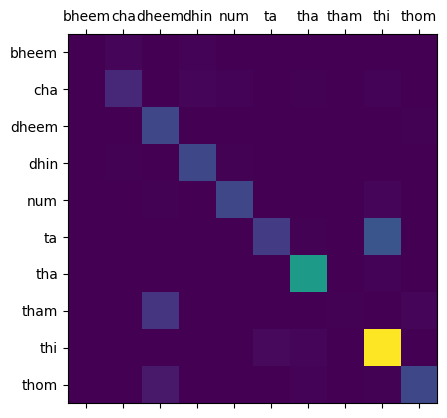

In [22]:
#### Compute confusion matrix on the test set
confusion_matrix = model.test_cm.compute().cpu().numpy()
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.matshow(confusion_matrix)
ax.set_xticks(range(len(train_dataset.label_map)))
ax.set_yticks(range(len(train_dataset.label_map)))
ax.set_xticklabels(train_dataset.label_map)
ax.set_yticklabels(train_dataset.label_map)
plt.show()